In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm, kstest

# Oxford
`OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries`

| Cell ID                                | Anode    | Cathode | Source  | Ah   | Form Factor | Temperature (C) | Max SOC | Min SOC | Charge Rate (C) | Discharge Rate (C) |
|----------------------------------------|----------|---------|---------|------|-------------|-----------------|---------|---------|-----------------|--------------------|
| OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries | graphite | LCO     | oxford  | 0.74 | pouch       | 40.00           | 100.00  | 0.00    | 2.00            | 1.84               |

## Limpeza e preparação

- Corrente negativa --> descarga
- Corrente positiva --> carga

In [2]:
# Header completo:
# Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
df = pd.read_csv('Battery_Archive_Data/Oxford/OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries.csv')

# Apenas features de interesse são mantidas
# Obs: Envoironment_Temperature (C) poderia ser relevante, mas tem todos os valores nulos. Então, é removida
df = df[["Cycle_Index", "Test_Time (s)", "Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]]

# Mantem apenas as linhas em que a bateria está descarregando, ou seja, corrente < 0
df = df[df['Current (A)'] < 0]

# Remove valores para Cell_Temperature < 1 (incorretos)
df = df[df['Cell_Temperature (C)'] >= 1]

display(df)
display(df.describe())

,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
1,1.0,9.990000e-01,-0.74,4.175,0.000,40.051
2,1.0,1.999000e+00,-0.74,4.174,0.000,39.988
3,1.0,2.999000e+00,-0.74,4.172,0.000,39.976
4,1.0,3.999000e+00,-0.74,4.171,0.000,39.964
5,1.0,4.999000e+00,-0.74,4.170,0.001,39.988
...,...,...,...,...,...,...
457802,8200.0,5.517855e+07,-0.74,3.336,0.528,41.249
457803,8200.0,5.517855e+07,-0.74,3.335,0.528,41.237
457804,8200.0,5.517855e+07,-0.74,3.333,0.528,41.199
457805,8200.0,5.517855e+07,-0.74,3.332,0.529,41.224


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
count,227455.000000,2.274550e+05,2.274550e+05,227455.000000,227455.000000,227455.000000
mean,3967.207615,2.669858e+07,-7.400000e-01,3.765557,0.305788,40.523928
std,2444.986810,1.680400e+07,2.220451e-16,0.195065,0.179824,0.470356
min,1.000000,9.990000e-01,-7.400000e-01,2.699000,0.000000,39.614000
25%,1900.000000,1.224665e+07,-7.400000e-01,3.656000,0.151000,40.113000
50%,3900.000000,2.608378e+07,-7.400000e-01,3.759000,0.303000,40.400000
75%,6100.000000,4.162771e+07,-7.400000e-01,3.902000,0.455000,40.912000
max,8200.000000,5.517871e+07,-7.400000e-01,4.176000,0.741000,41.699000


## Visualização

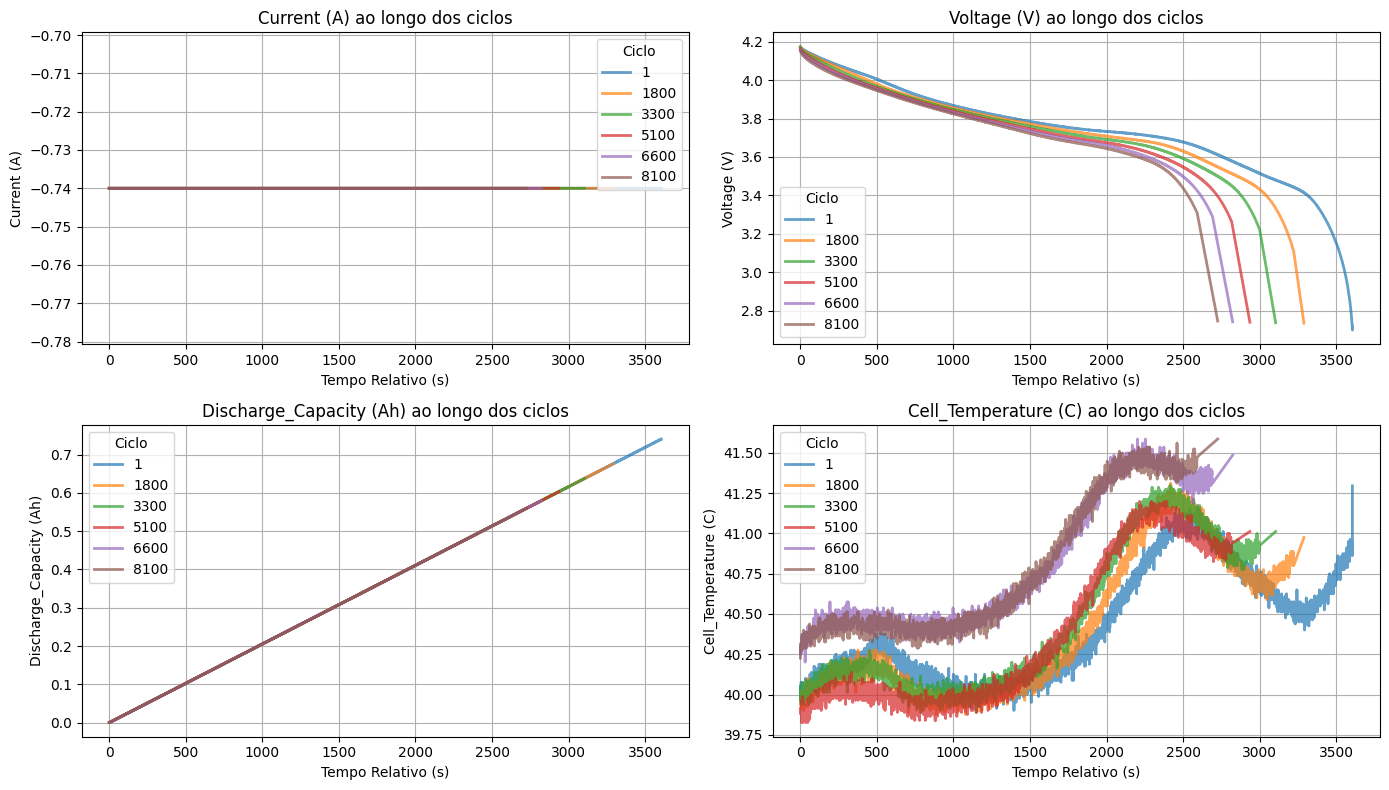

In [3]:
# Lista de features que deseja analisar (exceto "Cycle_Index")
features = ["Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]

# Ciclos únicos e ordenados
cycles = df["Cycle_Index"].unique()
cycles.sort()
NumCyclesPlot = 5

# Seleciona 'NumCyclesPlot' ciclos igualmente espaçados para plotar
if len(cycles) > NumCyclesPlot:
    cycles = cycles[::len(cycles)//NumCyclesPlot] # // --> Divisão inteira

# Cria os subplots com layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()  # Facilita a iteração

# Itera sobre cada feature e sobre os ciclos para plotar os dados
for i, feature in enumerate(features):
    ax = axs[i]
    for cycle in cycles:
        # Seleciona os dados do ciclo e calcula o tempo relativo
        df_cycle = df[df["Cycle_Index"] == cycle].copy()
        df_cycle['Tempo_Relativo (s)'] = df_cycle["Test_Time (s)"] - df_cycle["Test_Time (s)"].min()
        
        # Plota a feature em função do tempo relativo
        ax.plot(df_cycle['Tempo_Relativo (s)'], df_cycle[feature], alpha=0.7, label=f'{int(cycle)}', linewidth=2.0)

    ax.set_title(f'{feature} ao longo dos ciclos')
    ax.set_xlabel('Tempo Relativo (s)')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(title="Ciclo", loc='best')

plt.tight_layout()
plt.show()


## Análise de SOH

$$
\text{SOH} = \frac{\text{capacidade\_atual}}{\text{capacidade\_inicial}}
$$

- $CapacidadeInicial$ é a capacidade nominal, a maior considerando todo o histórico da bateria
- $CapacidadeAtual$ é a maior capacidade do ciclo

In [4]:
# Capacidade nominal (máxima global)
nominal_capacity = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

# Para cada ciclo, extrai a maior capacidade 
# (cycles_capacity é uma série do Pandas)
cycles_capacity = df.groupby('Cycle_Index')['Discharge_Capacity (Ah)'].max()
cycles_capacity = cycles_capacity.reset_index() # transforma em dataframe
cycles_capacity.columns = ['Cycle_Index', 'Max_Discharge_Capacity']
cycles_capacity['SOH_discharge'] = (cycles_capacity['Max_Discharge_Capacity'] / nominal_capacity)
display(cycles_capacity)

Capacidade total de descarga: 0.741 Ah


,Cycle_Index,Max_Discharge_Capacity,SOH_discharge
0,1.0,0.741,1.000000
1,100.0,0.732,0.987854
2,200.0,0.728,0.982456
3,300.0,0.725,0.978408
4,400.0,0.720,0.971660
...,...,...,...
72,7800.0,0.564,0.761134
73,7900.0,0.564,0.761134
74,8000.0,0.563,0.759784
75,8100.0,0.560,0.755735


In [5]:
# Seleciona as features de interesse e agrupa por ciclo
df_grouped = df[['Cycle_Index', 'Cell_Temperature (C)']]
df_grouped = df_grouped.groupby('Cycle_Index', as_index=False).mean() # Média será usada para a temperatura

# Adição do SOH calculado em ciclos_capacity
df_grouped['SOH_discharge'] = cycles_capacity['SOH_discharge']

display(df_grouped)
display(df_grouped.describe())

,Cycle_Index,Cell_Temperature (C),SOH_discharge
0,1.0,40.419166,1.000000
1,100.0,40.319742,0.987854
2,200.0,40.317441,0.982456
3,300.0,40.311226,0.978408
4,400.0,40.304815,0.971660
...,...,...,...
72,7800.0,40.733336,0.761134
73,7900.0,40.738304,0.761134
74,8000.0,40.720570,0.759784
75,8100.0,40.774364,0.755735


,Cycle_Index,Cell_Temperature (C),SOH_discharge
count,77.000000,77.000000,77.000000
mean,4188.324675,40.537653,0.847942
std,2448.283784,0.178534,0.069428
min,1.000000,40.227923,0.755735
25%,2200.000000,40.379861,0.788124
50%,4200.000000,40.470904,0.835358
75%,6300.000000,40.733336,0.896086
max,8200.000000,40.801851,1.000000


### [numpy.interp() parameters](https://numpy.org/doc/2.1/reference/generated/numpy.interp.html):
- `x`: _array_like_ . The x-coordinates at which to evaluate the interpolated values.

- `xp`: _1-D sequence of floats_. The x-coordinates of the data points, must be increasing if argument period is not specified. Otherwise, xp is internally sorted after normalizing the periodic boundaries with xp = xp % period.

- `fp`: _1-D sequence of float or complex_. The y-coordinates of the data points, same length as xp.

Returns the one-dimensional piecewise linear interpolant to a function with given discrete data points (xp, fp), evaluated at x:
- `y`: float or complex (corresponding to fp) or ndarray. The interpolated values, same shape as x.

In [6]:
# Define thresholds de interesse (99%, 98%, ...)
thresholds = np.arange(0.99, 0.00, -0.01)

soh    = df_grouped['SOH_discharge'].values
cycles = df_grouped['Cycle_Index'].values

# inverte para que fique crescente
xp = soh[::-1]
fp = cycles[::-1]

valid = (thresholds >= xp.min()) & (thresholds <= xp.max())
thresholds = thresholds[valid]

# np.interp(x, xp, fp) assume xp crescente e retorna y para cada x em thresholds
estimated_cycles = np.interp(thresholds, xp, fp)

df_estimates = pd.DataFrame({
    'SOH_threshold':   thresholds,
    'estimated_cycle': estimated_cycles
})

# Number of cycles drop (1%)
df_estimates['NCD1%'] = df_estimates['estimated_cycle'].diff()

# Cast
df_estimates['estimated_cycle'] = df_estimates['estimated_cycle'].astype(int)
df_estimates['SOH_threshold']   = df_estimates['SOH_threshold'].astype(float).round(2)

display(df_estimates)


,SOH_threshold,estimated_cycle,NCD1%
0,0.99,82,NaN
1,0.98,260,178.156667
2,0.97,440,180.333333
3,0.96,652,211.800000
4,0.95,851,198.450000
5,0.94,1082,230.750000
6,0.93,1343,261.500000
7,0.92,1609,265.833333
8,0.91,1856,247.000000
9,0.90,2103,247.000000


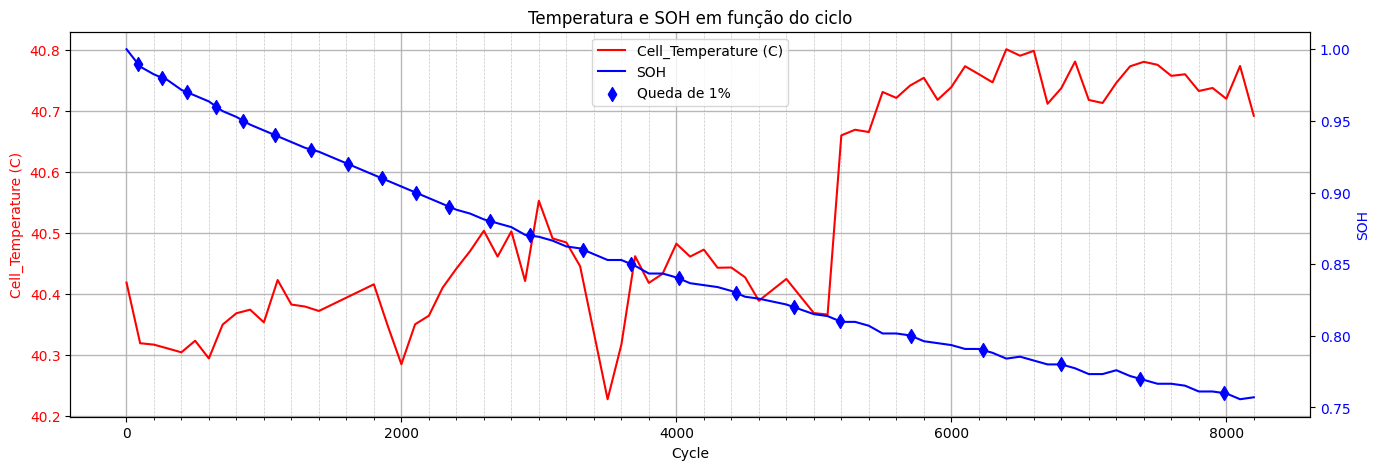

In [11]:
fig, ax1 = plt.subplots(figsize=(16,5))

# Eixo temperatura
ax1.plot(df_grouped["Cycle_Index"], df_grouped["Cell_Temperature (C)"], label="Cell_Temperature (C)", color='red')
ax1.set_xlabel("Cycle")
ax1.set_ylabel("Cell_Temperature (C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Major ticks: 1, 2000, 4000, ...
xmin = df_grouped["Cycle_Index"].min()
xmax = df_grouped["Cycle_Index"].max()
major_ticks = np.arange(0, xmax+1, 2000)
ax1.set_xticks(major_ticks)

# Minor ticks: a cada 200 unidades
minor_ticks = np.arange(0, xmax+1, 200)
ax1.set_xticks(minor_ticks, minor=True)

# Grids
ax1.grid(which='major', linestyle='-', linewidth=1, alpha=0.9)
ax1.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.7)

# Eixo SOH
ax2 = ax1.twinx()
ax2.plot(df_grouped["Cycle_Index"], df_grouped["SOH_discharge"], label="SOH", color='blue')
ax2.set_ylabel("SOH", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.scatter(df_estimates["estimated_cycle"], df_estimates["SOH_threshold"], color='blue', marker='d', s=50, label="Queda de 1%")

plt.title("Temperatura e SOH em função do ciclo")

# Combina as legendas dos dois eixos
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.show()


Média: 343.54, Desvio-padrão: 135.13


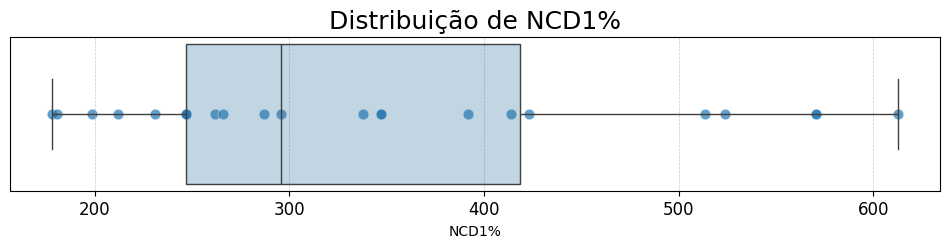

In [8]:
data = df_estimates["NCD1%"].dropna().values

mean = np.mean(data)
std  = np.std(data, ddof=1)
print(f'Média: {mean:.2f}, Desvio-padrão: {std:.2f}')

# Seleciona a cor padrão 'C0' do matplotlib (primeira cor)
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, ax = plt.subplots(figsize=(12, 2))

sns.boxplot(
    x=data,                   # valores no eixo x
    y=np.zeros_like(data),    # posição 0 no eixo y
    ax=ax,
    orient='h',
    linewidth=1,
    zorder=2
)

# Deixa a face do boxplot semitransparente
for patch in ax.patches:
    if hasattr(patch, 'get_facecolor'):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))  # alpha = 0.3

# Sobreposição de pontos (scatter) com baixa opacidade
sns.scatterplot(
    x=data,
    y=np.zeros_like(data),
    ax=ax,
    s=60,                     # tamanho dos pontos
    color=default_color,      # mesma cor do boxplot
    alpha=0.7,
    zorder=1
)

# Remove os ticks do eixo y (não fazem sentido aqui)
ax.set_yticks([])

ax.set_xlabel("NCD1%")
ax.tick_params(which='major', labelsize=12)

plt.title("Distribuição de NCD1%", fontsize=18)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

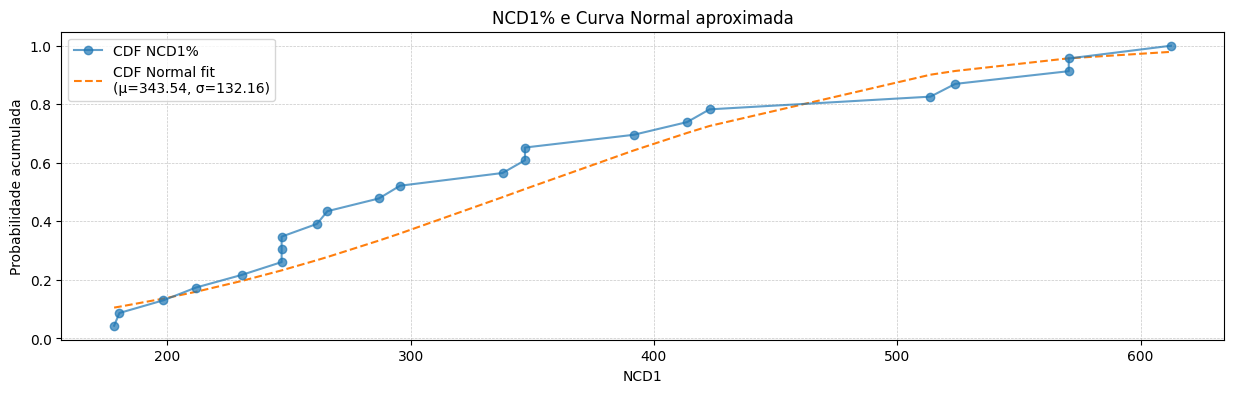

In [9]:
data = np.sort(data)  # Garante que os dados estão ordenados
n    = len(data)

# Faz o fitting para encotnrar os parametros e calcula a funcao acumulada dos dados considerando comportamento normal
mean, std = norm.fit(data)
teo_norm  = norm.cdf(data, loc=mean, scale=std)

plt.figure(figsize=(15, 4))

# Probabilidade acumulada empírica (1/n, 2/n, ..., 1)
cdf_emp = np.arange(1, n+1) / n
plt.plot(data, cdf_emp, marker='o', linestyle='-', label="CDF NCD1%", zorder=3, alpha=0.7)

# Função acumulada da normal (teórica)
plt.plot(data, teo_norm, linestyle='--', label=f"CDF Normal fit\n(μ={mean:.2f}, σ={std:.2f})")

plt.xlabel("NCD1")
plt.ylabel("Probabilidade acumulada")
plt.title("NCD1% e Curva Normal aproximada")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()


Teste de Kolmogorov–Smirnov (KS) para verificar formalmente se o conjunto de dados de NCD1% (`data`) segue a distribuição Normal com os parametros encontrados no método de fitting

De acordo com a [documentação de **kstest**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html):
- ``rvs=data``
    - Array de observações ordenadas
- ``cdf='norm'`` 
    - Especifica que a distribuição teórica é a de uma normal
- ``args=(mean, std)`` 
    - Parâmetros (μ, σ) da normal teórica

Retorna:

- ``D (statistic) `` 
    - Representa a maior diferença absoluta entre aa curva dados e a CDF da Normal teórica
    - Quanto menor, mais próximo o ajuste está dos dados observados

- ``p-value``
    - Probabilidade de observar uma estatística \( D \) igual ou mais extrema sob a suposição de que os dados vêm de uma Normal
    - **Valores altos (> alpha) indicam falha em rejeitar a hipótese de normalidade**. 
    - Valores baixos (< alpha) indicam evidência contra a hipótese

In [10]:
statistic, p_value = kstest(rvs=data, cdf='norm', args=(mean, std))

print(f"KS statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05 # não tenho certeza em qual valor usar aqui, mas 0.05 pareceu ser comum
print(f'alpha = {alpha}')
if p_value < alpha: print(f"Hipótese rejeitada.")
else: print(f"Hipótese aceita.")

KS statistic: 0.1632
p-value: 0.5204
alpha = 0.05
Hipótese aceita.
